In [1]:
%matplotlib inline

# Import Dependencies

In [2]:
# Data analysis
import pandas as pd
import numpy as np
# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Data Exploration

In [3]:
df = pd.read_csv('dataset_1.csv')
df.head()

,Date,Time (Local),Eyeballs,Zeroes,Completed Trips,Requests,Unique Drivers
0,10-Sep-12,7,5,0,2,2,9
1,NaN,8,6,0,2,2,14
2,NaN,9,8,3,0,0,14
3,NaN,10,9,2,0,1,14
4,NaN,11,11,1,4,4,11


Forward fill the date column to handle missing values.

In [4]:
df['Date'].fillna(method='ffill', inplace=True)
df.head()

,Date,Time (Local),Eyeballs,Zeroes,Completed Trips,Requests,Unique Drivers
0,10-Sep-12,7,5,0,2,2,9
1,10-Sep-12,8,6,0,2,2,14
2,10-Sep-12,9,8,3,0,0,14
3,10-Sep-12,10,9,2,0,1,14
4,10-Sep-12,11,11,1,4,4,11


Next, convert the date column to `datetime` by manually specifying the right string format.

In [5]:
df['Date'].unique()

array(['10-Sep-12', '11-Sep-12', '12-Sep-12', '13-Sep-12', '14-Sep-12',
       '15-Sep-12', '16-Sep-12', '17-Sep-12', '18-Sep-12', '19-Sep-12',
       '20-Sep-12', '21-Sep-12', '22-Sep-12', '23-Sep-12', '24-Sep-12'],
      dtype=object)

In [6]:
df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')
df.head()

,Date,Time (Local),Eyeballs,Zeroes,Completed Trips,Requests,Unique Drivers
0,2012-09-10,7,5,0,2,2,9
1,2012-09-10,8,6,0,2,2,14
2,2012-09-10,9,8,3,0,0,14
3,2012-09-10,10,9,2,0,1,14
4,2012-09-10,11,11,1,4,4,11


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              336 non-null    datetime64[ns]
 1   Time (Local)      336 non-null    int64         
 2   Eyeballs          336 non-null    int64         
 3   Zeroes            336 non-null    int64         
 4   Completed Trips   336 non-null    int64         
 5   Requests          336 non-null    int64         
 6   Unique Drivers    336 non-null    int64         
dtypes: datetime64[ns](1), int64(6)
memory usage: 18.5 KB


Finally, handle the data entry errors by striping leading/trailing white spaces in the column names.

In [8]:
df.columns

Index(['Date', 'Time (Local)', 'Eyeballs ', 'Zeroes ', 'Completed Trips ',
       'Requests ', 'Unique Drivers'],
      dtype='object')

In [9]:
df.columns = df.columns.str.strip()

### 1. Which date had the most completed trips during the two week period?

In [10]:
df_1 = df.groupby(['Date'])['Completed Trips'].sum()
df_1

Date
2012-09-10     26
2012-09-11     40
2012-09-12     91
2012-09-13     45
2012-09-14    108
2012-09-15    199
2012-09-16     93
2012-09-17     57
2012-09-18     42
2012-09-19     41
2012-09-20     70
2012-09-21    190
2012-09-22    248
2012-09-23    111
2012-09-24      4
Name: Completed Trips, dtype: int64

In [11]:
df_1[df_1 == df_1.max()]

Date
2012-09-22    248
Name: Completed Trips, dtype: int64

Answer: September 22, 2012

### What was the highest number of completed trips within a 24 hour period?

In [28]:
df_2 = df['Completed Trips'].rolling(24).sum()
df_2

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
331    61.0
332    52.0
333    52.0
334    53.0
335    54.0
Name: Completed Trips, Length: 336, dtype: float64

In [29]:
df_2.max()

278.0

Answer: 278

### Which hour of the day had the most requests during the two week period?

In [14]:
df_3 = df.groupby(['Time (Local)'])['Requests'].sum()
df_3

Time (Local)
0     142
1      96
2     100
3      35
4       9
5      14
6      28
7      22
8      29
9      26
10     28
11     47
12     53
13     55
14     71
15     71
16     82
17     98
18    119
19    156
20    107
21    112
22    174
23    184
Name: Requests, dtype: int64

In [15]:
df_3[df_3 == df_3.max()]

Time (Local)
23    184
Name: Requests, dtype: int64

Answer: 2300 - 0000

### What percentages of all zeroes during the two week period occurred on weekend (Friday at 5 pm to Sunday at 3 am)? 

Tip: The local time value is the start of the hour (e.g. 15 is the hour from 3:00pm - 4:00pm)

In [30]:
df_4 = df.copy()
df_4['Day'] = pd.to_datetime(df_4['Date']).dt.dayofweek

weekend_zeroes = df_4[(((df_4['Day'] == 4) & (df_4['Time (Local)'] >= 17))
                        | (df_4['Day'] == 5) 
                        | ((df_4['Day'] == 6) & (df_4['Time (Local)'] <= 2)))]['Zeroes'].sum()
total_zeroes = df_4['Zeroes'].sum()

print(f'{weekend_zeroes / total_zeroes * 100:.2f}%')

44.86%


Answer: 44.86%

### What is the weighted average ratio of completed trips per driver during the two week period? 

Tip: "Weighted average" means your answer should account for the total trip volume in each hour to determine the most accurate number in whole period.

In [19]:
df_5 = df.copy()
# Remove rows where unique drivers = 0
df_5 = df_5.loc[df_5['Unique Drivers'] > 0]
# Find completed trips per driver for each hour
df_5['Completed Trips per Driver'] = df_5['Completed Trips'] / df_5['Unique Drivers']
# Compute weights (percentage of completed trips) for each hour
df_5['Percentage of Completed Trips'] = df_5['Completed Trips'] / df_5['Completed Trips'].sum()
# Get weighted average
print(np.average(df_5['Completed Trips per Driver'] * df_5['Percentage of Completed Trips']))

0.002788813372084982


In [20]:
# Verify that the weighted average is different from the average
print(np.average(df_5['Completed Trips per Driver']))

0.4743397876937869


Answer: 0.0028 completed trips per driver

### In drafting a driver schedule in terms of 8 hours shifts, when are the busiest 8 consecutive hours over the two week period in terms of unique requests? A new shift starts in every 8 hours. Assume that a driver will work same shift each day.

In [21]:
# Find total unique requests for each hour across 2 week period
df_6 = df.groupby(['Time (Local)'])['Requests'].sum()
# Calculate rolling 8 hour sum of total requests
df_6 = pd.concat([df_6[17:], df_6], axis=0)
df_6 = df_6.rolling(8).sum()
# Find window where rolling sum is maximized (shift starts 7 hours before indexed time)
df_6[df_6 == df_6.max()]

Time (Local)
0    1092.0
Name: Requests, dtype: float64

Answer: 1700 - 0100

### True or False: Driver supply always increases when demand increases during the two week period. 

Tip: Visualize the data to confirm your answer if needed.

In [22]:
df_7 = df.copy()
df_7['Delta Requests'] = df_7['Requests'].rolling(2).apply(lambda x: x.iloc[1] - x.iloc[0])
df_7['Delta Drivers'] = df_7['Unique Drivers'].rolling(2).apply(lambda x: x.iloc[1] - x.iloc[0])
df_7.dropna(inplace=True)
df_7

,Date,Time (Local),Eyeballs,Zeroes,Completed Trips,Requests,Unique Drivers,Delta Requests,Delta Drivers
1,2012-09-10,8,6,0,2,2,14,0.0,5.0
2,2012-09-10,9,8,3,0,0,14,-2.0,0.0
3,2012-09-10,10,9,2,0,1,14,1.0,0.0
4,2012-09-10,11,11,1,4,4,11,3.0,-3.0
5,2012-09-10,12,12,0,2,2,11,-2.0,0.0
...,...,...,...,...,...,...,...,...,...
331,2012-09-24,2,3,3,0,2,0,2.0,0.0
332,2012-09-24,3,3,3,0,1,0,-1.0,0.0
333,2012-09-24,4,1,1,0,0,0,-1.0,0.0
334,2012-09-24,5,4,2,1,1,3,1.0,3.0


In [23]:
# Check if demand increases when supply increases
(df_7[df_7['Delta Drivers'] > 0]['Delta Requests'] > 0).all()

False

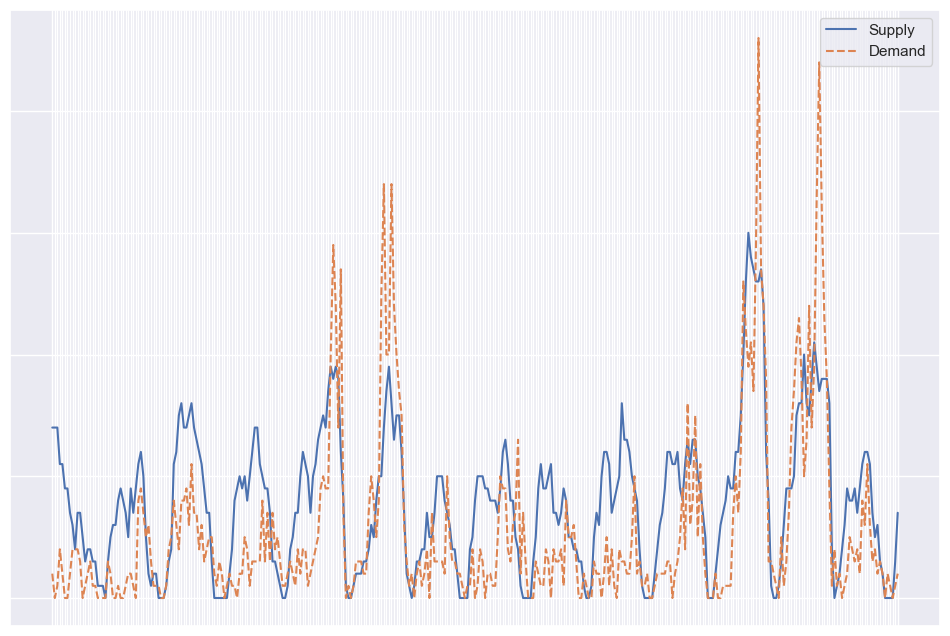

In [24]:
# Verify our answer by visualizing the data
df_7['Datetime'] = df_7['Date'].astype(str) + ' : ' + df_7['Time (Local)'].astype(str)
# Make plots
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(df_7['Datetime'], df_7['Unique Drivers'])
ax.plot(df_7['Datetime'], df_7['Requests'], linestyle='--')
# Create legend
ax.legend(['Supply', 'Demand'])
# Turn off tick labels
ax.set_yticklabels([])
ax.set_xticklabels([])

plt.show()

Answer: False

### In which 72 hour period is the ratio of Zeroes to Eyeballs the highest?

In [25]:
df_8 = df.copy()
df_8.set_index(['Date', 'Time (Local)'], inplace=True)
df_8 = df_8[['Zeroes', 'Eyeballs']].rolling(72).sum()
df_8.dropna(inplace=True)
df_8['Zeroes to Eyeballs Ratio'] = df_8['Zeroes'] / df_8['Eyeballs']
df_8[df_8['Zeroes to Eyeballs Ratio'] == df_8['Zeroes to Eyeballs Ratio'].max()]

,,Zeroes,Eyeballs,Zeroes to Eyeballs Ratio
Date,Time (Local),,,
2012-09-18,4,438.0,1495.0,0.292977


Answer: 2012-09-16 05:00 to 2012-09-18 05:00

### If you could add 5 drivers to any single hour of every day during the two week period, which hour should you add them to? 

Hint: Consider both rider eyeballs and driver supply when choosing

In [42]:
# Get total eyeballs and drivers for each hour over 2 weeks
df_9 = df.groupby(['Time (Local)'])[['Eyeballs', 'Unique Drivers']].sum()
# Remove rows where eyeballs = 0
df_9 = df_9[df_9['Eyeballs'] > 0]
# Find drivers per eyeball for each hour
df_9['Drivers per Eyeball'] = df_9['Unique Drivers'] / df_9['Eyeballs']
# Get hour with min value (would gain most from adding 5 drivers)
df_9[df_9['Drivers per Eyeball'] == df_9['Drivers per Eyeball'].min()]

,Eyeballs,Unique Drivers,Drivers per Eyeball
Time (Local),,,
23,488,119,0.243852


Answer: 2300 - 0000

## True or False: There is exactly two weeks of data in this analysis

In [26]:
df_10 = df.copy()
df_10['Datetime'] = df['Date'].astype(str) + ' ' + df['Time (Local)'].astype(str)
# 24 hrs/day * 14 days = 336 entries
len(df_10['Datetime'].unique())

336

Answer: True

## Looking at the data from all two weeks, which time might make the most sense to consider a true "end day" instead of midnight? (i.e when are supply and demand at both their natural minimums) 

Tip: Visualize the data to confirm your answer if needed.

In [52]:
df_11 = df.groupby(['Time (Local)'])[['Requests', 'Unique Drivers']].sum()
# Find time where requests are minimized
df_11[df_11['Requests'] == df_11['Requests'].min()]

,Requests,Unique Drivers
Time (Local),,
4,9,9


In [53]:
# Find time where drivers are minimized
df_11[df_11['Unique Drivers'] == df_11['Unique Drivers'].min()]

,Requests,Unique Drivers
Time (Local),,
4,9,9


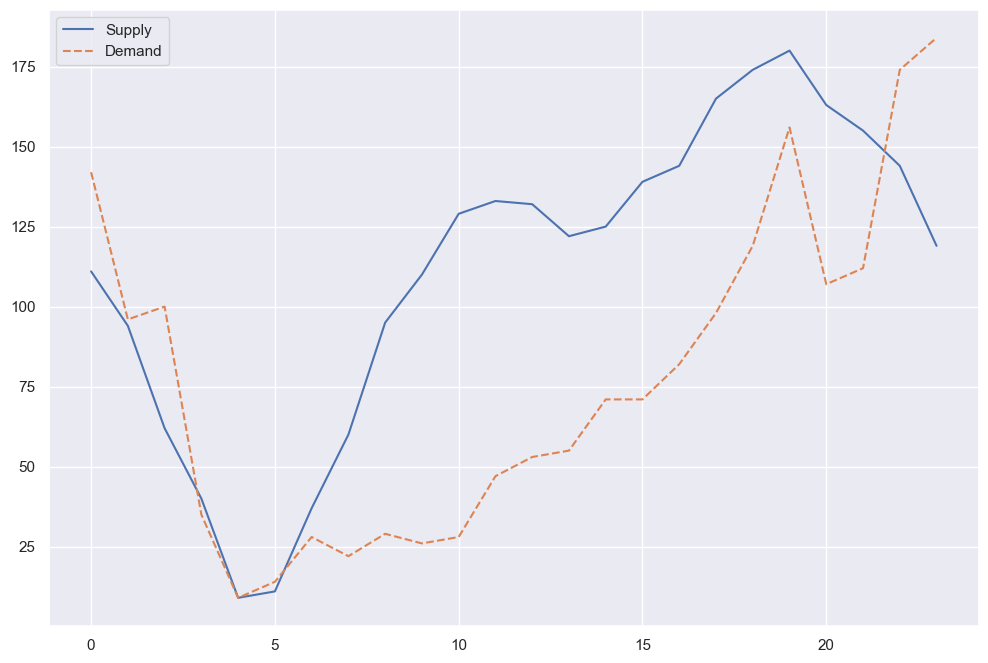

In [55]:
# Verify our answer by visualizing the data
df_11.reset_index(inplace=True)
# Make plots
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(df_11['Time (Local)'], df_11['Unique Drivers'])
ax.plot(df_11['Time (Local)'], df_11['Requests'], linestyle='--')
# Create legend
ax.legend(['Supply', 'Demand'])

plt.show()

Answer: 0400